# Will a data scientist leave your company?

**Introduction**

* The objective of this kernel is to predict whether a data scientist would leave the company or continue working there.

* I plan to use the HR_Analytics dataset to find an optimal set of parameters that would allow us to estimate the probability of an employee leave. This is a classification problem, thus I would apply various classification models for the assessment of the relationship between independent variables and the dependent variable (target) in this dataset.

* I have compared the most common classifiers and found that XGBoost classifier resulted in the highest recall score of 0.80 of those who plan to leave. I have opted for recall as a ultimate metrics because in this project we are trying to minimize the falls negative values, meaning: if we predicted that a person would not leave our company, but he or she actually did it, we would loose an average **60000$** as cost to hire a new specialist for this role. Thus, it is better if we predicted that a person would indeed leave the company, but he decided to stay (False positive), than other way around (False negative).

*** Please do UpVote this Notebook if you find it helpful!**

 <a></a>
# Table of contents

1. [Quick glance at Data](#Quick-glance-at-the-Data)

2. [My Hypothesis](#Hypothesis)

3. [Exploratory Data Analysis](#EDA)

4. A) Feature Engineering: [Data Clustering](#Data_Clustering)

5. B) Feature Engineering: [Missing values](#Missing_Values)

6. [Feature Selection](#Feature_Selection)

7. [Model Building](#Model_Building)

8. [Hyperparameter tuning](#Hyperparameter_Tuning)

8. [Model Evaluation](#Model_Evaluation)

9. [Deployment](#Deployment)

In [ ]:
# import packages for analysis
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,8)
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, classification_report, plot_roc_curve, roc_auc_score, roc_curve 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
import plotly.express as px
from matplotlib.pyplot import figure
from collections import defaultdict
import random
plt.style.use('ggplot')
pd.options.mode.chained_assignment = None
from collections import defaultdict
from imblearn.pipeline import Pipeline as imbPipe
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score,roc_curve
from imblearn.pipeline import Pipeline as imbPipe
from imblearn.over_sampling import SMOTE
from xgboost import  XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings("ignore")


<a class = 'anchor' id = 'Quick-glance-at-the-Data'></a>

# Quick glance at Data

In [ ]:
#import libraries to read the file
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
df_train = pd.read_csv('/kaggle/input/hr-analytics-job-change-of-data-scientists/aug_test.csv')
df_test = pd.read_csv('/kaggle/input/hr-analytics-job-change-of-data-scientists/aug_train.csv')

#I got used to work with complete datasets, thus I will just combine test and train datasets
df = df_train.append(df_test)
df.head()

In [ ]:
# shape and data types of the data
print(df.shape)
print(df.dtypes)
print()
print('Numeric columns:')
# select numeric columns
df_numeric = df.select_dtypes(include=[np.number])
numeric_cols = df_numeric.columns.values
print(numeric_cols)
print()
print('Non-numeric columns:')
# select non numeric columns
df_non_numeric = df.select_dtypes(exclude=[np.number])
non_numeric_cols = df_non_numeric.columns.values
print(non_numeric_cols)

Quick summary:
Most features are categorical (Nominal, Ordinal)

Features:
* enrollee_id : Unique ID of employee
* city: City code
* city_development_index: Developement index of the city (scaled)
* gender: Gender of employee
* relevent_experience: Relevent experience of employee
* enrolled_university: Type of University courses employee if any
* education_level: Education level of employee
* major_discipline :Education major discipline of employee
* experience: employee total experience in years
* company_size: No of employees in current employer's company
* company_type : Type of current employer
* lastnewjob: Difference in years between previous job and current job
* training_hours: training hours completed
* target: 0 – Not looking for job change, 1 – Looking for a job change

<a class = 'anchor' id = 'Hypothesis'></a>

# My Hypothesis

**My initial hypothesis was that relevant_experience, training_hours and experience would influence the candidate's decision to leave the company at most**

<a class = 'anchor' id = 'EDA'></a>

# Exploratory Data Analysis

In [ ]:
#working with missing values
cols = df.columns 
colours = ['#000099', '#ffff00'] # specify the colours - yellow is missing. blue is not missing.
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours))

Regarding missing values, we we will perform exploratory data analysis, and then we will estimate the feature importance of each independent variable in respect to the target feature, so we will not have to impute nan values for all variables, just for those that significantly correlated with the target.

In [ ]:
# lets see the density distribution of the numerical columns corresponding target features
df_numeric.columns

for i in df_numeric.columns[:-1]:
    sns.set(font_scale=1.5)
    plt.figure(figsize=[10,6])
    ax = sns.kdeplot(df_numeric[i][(df_numeric["target"] == 1) ],color="red", bw = .05, shade=False, gridsize=300)
    ax = sns.kdeplot(df_numeric[i][(df_numeric["target"] == 0) ],color="blue", bw=.05, shade=False, gridsize=300)
    ax.legend(["Looking for a new job","Not looking for new job job"],loc='upper left')
    ax.set_ylabel('Density')
    ax.set_xlabel(i)
    ax.set_title("Distribution of "+ i +" by Job change");

According to the EDA analysis of numeric columns, enrolee_id has no effect on the target feature, however city_development index did influence the target: job candidates living in cities with lower development index **look for a new job 3 times more frequently** than those who prefer to stay in the company. Regarding the cities with high development index, the number of employees planning to leave the job is **around 2 times lower** than those who intended to stay. I could not observe a clear dependence of those who got trained less or more on their tendency to leave or stay in the company.

In [ ]:
df.columns

In [ ]:
#droping less important columns
df1 = df.copy()
df1.drop(columns = ['enrollee_id', 'training_hours'], inplace = True)

In [ ]:
# Lets take a look at the target feature
sns.set(font_scale=1.5)
sns.countplot(data=df, x='target')
plt.show()

The target variable is clearly imbalanced , we can deal with it later, in the data preprocessing section. We observe that most of the data scientist 3 times more decided to stay in company. We should not be surprised when this proportion (0/1) will appear during the EDA of categorical features.


In [ ]:
#Lets check how categorical features influence the target variable
df_non_numeric.columns[:-1]

In [ ]:
for i, col in enumerate(df_non_numeric.columns[1:]):
    sns.set(font_scale=1.5)
    plt.figure(i)
    plt.title("Countplot of {}  by Target".format(col),fontsize=20)
    g= sns.countplot(x=col, hue = 'target', data=df)
    g.set_xlabel(col, fontsize = 20)
    plt.figure(figsize=[14,5])

**If there is no ifluence of the independent variable onto the target feature, we are supposed to get the ratio of 3 to 1 for 0 and 1 (target feature) according to the countplot above of target feature. If the ratio of 0 and 1 is different from 3 to 1 (3/1), that means that there is an effect (positive or negative) on the independent variable onto the target feature.**

1. We observe that there are more male than female data scientist. Gender however did not influence the target feature: the ratio of 0 and 1 distribution relatively similar to the graph above(countplot of the target feature).
2. Job candidates without relevant_experience are a bit more prone to leave the company that candidates with relevant_experience: ratio (0 and 1) is 2/1 for people without relevent experience. We conclude that because the ratio (2/1) is bigger than 3/1 for target feature distribution of 0 and 1.
3. Students enrolled into full course would tend to leave the company at higher rate (2.4/1) than those without enrollment.
4. Graduate student are a bit more confident and look freely for a new job than other student (2.5/1) comparing to standard countplot of target feature (3/1).
5. Major_discipline and company_type would not really affect the target variable
6. Data scientist who never had a job intend to leave the company more frequently.
7. Company_size and experience need further investigation, but we see than experience data scientists with more than 20 years of experience are more faithful to the company than other categories.

**My updated hypostesis: It looks like that I was wrong saying that relevant_experience, training_hours and experience would play a major role in determining teh terget feature. In contrast, according to the EDA analysis it looks like that only city_development index would considerably influence the employee decision whether to stay or to leave the company.**

In [ ]:
df1.columns

In [ ]:
# droping less important columns
# city columns itself could serve as index, but I prefer to just drop it
df1.drop(columns = ['city', 'gender', 'major_discipline', 'company_type'], inplace = True)

<a class = 'anchor' id = 'Data_Clustering'></a>

# Feature Engineering: Data Clustering

In this section we will do some Data Preprocessing for company_size and experience to reduce the number of values in those columns by clustering them

In [ ]:
#starting with experience column
#this is what we have right after EDA analysis
sns.set(font_scale=1.5)
sns.barplot(x=df['experience'], y = 'target', data=df)

kind of difficult to grasp what is going on here, thus lets transform the data into 4 clusters

In [ ]:
df1.head()

In [ ]:

#some data cleaning and preprocessing
df1['experience'] = df1['experience'].replace('<1', '1').replace('>20', '20')

#necessary float conversion for cut function
df1['experience'] = df1['experience'].astype(float)

#Looking at the number of years in experience column I have decided to separate them into 4 groups:
#junior, middle, senior, and expert
df1['experience'] = pd.cut(df1['experience'], bins=4,  
                      labels=['junior', 'middle', 'senior', 'expert']) 



In [ ]:
#Lets see what we got
sns.set(font_scale=1.5)
sns.barplot(x=df1['experience'], y = 'target', data=df1)

Looking good!

In [ ]:
#Lets see what we got
sns.set(font_scale=1.5)
sns.countplot(x=df1['experience'], hue = 'target', data=df1)

We remember that the initial distribution of 0 and 1 for the target feature is 3/1, so, for junior this ratio is about 2/1 (more ones than zeroes than for initial distribution of the target feature), meaning that Junior  most likely would leave the job whereas expert prefer to stay in the company 4.5/1.

In [ ]:
#lets work with the compaby_size data
#this is what we right after EDA analysis
sns.set(font_scale=1.5)
sns.barplot(x=df['company_size'], y = 'target', data=df)

In [ ]:
#some data preprocessing
df1['company_size'] = df1['company_size'].replace('<10', '10').replace('10/49', '10-49')

#necessary float conversion for cur function
#temporarily substiturte the null values as 0, then we group this group as unknown
df1['company_size'] = df1['company_size'].fillna(0).astype(str)

#need to assign categories for each "categorical cluster" prior to imputation 
categories = np.array(['small', 'middle', 'large', 'unknown'])
categories

In [ ]:
# company_size data clustering into 5 categories
df1.loc[(df1['company_size'] == '10') | (df1['company_size'] == '10-49'),'company_size'] = 'ultra_small'
df1.loc[(df1['company_size'] == '50-99') | (df1['company_size'] == '100-500'),'company_size'] = 'small'
df1.loc[(df1['company_size'] == '500-999') | (df1['company_size'] == '1000-4999'),'company_size'] = 'medium'
df1.loc[(df1['company_size'] == '5000-9999') | (df1['company_size'] == '10000+'),'company_size'] = 'large'
df1.loc[(df1['company_size'] == '0'), 'company_size'] = 'unknown'
sns.set(font_scale=1.5)
sns.barplot(x=df1['company_size'], y = 'target', data=df1)

In [ ]:
#Lets see what we got
sns.set(font_scale=1.5)
sns.countplot(x=df1['company_size'], hue = 'target', data=df1)

We remember that the initial distribution of 0 and 1 for the target feature is 3/1, so,
for small and medium sized companies the ratio of 0 and 1 is about 5/1 meaning that employees tend to stay in those companies. For ultra small and large companies the distribution of 0 and 1 is about the 3/1, which is similar to the initial ration of 0 and 1 if target feature. There are many unknown values, which we need to take into account later.

After Feature Engineering we can narrow our search down to the following variables:
1. city_development_index
2. experience
3. enrolled_university
4. education_level
5. relevant_experience
6. last_new_job


<a class = 'anchor' id = 'Missing_values'></a>

# Feature Engineering: Missing values

In [ ]:
#Lets see what missing values we need to impute
missing = pd.DataFrame(df1.isnull().sum()/len(df1), columns=['Missing'])

cm = sns.light_palette("red", as_cmap=True)
missing.style.background_gradient(cmap=cm)

In [ ]:
df1.head()

**Handling categorical features_adding a variable to capture NAN**

I do not want to delete the nan values neither to impute them with 0 or median. I plan to find another feature from the dataset that has some meaningful correlarion with feature with nan values

In [ ]:
#Encoding the last_new_job variable
df1['last_new_job'] = df1['last_new_job'].replace('>4', 5).replace('never', 0)


In [ ]:
#Encoding the experience variable
exp = {'Has relevent experience': 0, 'No relevent experience': 1}
df1['relevent_experience'] = df1['relevent_experience'].map(exp)


In [ ]:
df.columns

**If we would observe the dependence of one independent feature on another one, we can tr to impute the m issing values based on this correlation, which is better that imputing nan's with 0 or median**

In [ ]:

sns.set(font_scale=1.5)
columns_to_plot = ['enrolled_university', 'education_level', 'last_new_job']

plt.figure(figsize=[20,6])
for column in columns_to_plot:
    
    ax = sns.factorplot(column, 'city_development_index', data=df1, size=4, aspect=2.5)
    plt.title("Countplot of {}  by target".format(column))
    
plt.tight_layout()
plt.show()

In [ ]:


#encoding enrolled_university missing values with correlated feature: city_development_index
df1.loc[(df1.enrolled_university.isnull()) & 
(df1.city_development_index >= 0.83),'enrolled_university']= 'no_enrollment'

df1.loc[(df1.enrolled_university.isnull()) & 
(df1.city_development_index <= 0.79),'enrolled_university']= 'Full time course'

df1.loc[(df1.enrolled_university.isnull()) & 
((df1.city_development_index > 0.79) 
 & (df1.city_development_index < 0.83)),'enrolled_university']= 'Part time course'

In [ ]:
#encoding education_level missing values with correlated feature: city_development_index
df1.loc[(df1.education_level.isnull()) & 
(df1.city_development_index > 0.85),'education_level']= 'PhD'

df1.loc[(df1.education_level.isnull()) & 
(df1.city_development_index < 0.83),'education_level']= 'Graduate'

df1.loc[(df1.education_level.isnull()) & 
(df1.city_development_index >= 0.83) & 
(df1.city_development_index <= 0.84),'education_level']= 'High School'


df1.loc[(df1.education_level.isnull()) & 
(df1.city_development_index >= 0.845) & 
(df1.city_development_index <= 0.85),'education_level']= 'High School'

In [ ]:
#encoding last_new_job missing values with correlated feature: city_development_index
df1.loc[(df1.last_new_job.isnull()) & 
        (df1.city_development_index <= 0.83) & (df1.city_development_index >= 0.80),'last_new_job']= 1


df1.loc[(df1.last_new_job.isnull()) & (df1.city_development_index > 0.83)
        & (df1.city_development_index <= 0.84),'last_new_job']= 2


df1.loc[(df1.last_new_job.isnull()) & (df1.city_development_index > 0.84)
        & (df1.city_development_index <= 0.86),'last_new_job']= 4


df1.loc[(df1.last_new_job.isnull()) & (df1.city_development_index > 0.86),'last_new_job']= 5

df1.loc[(df1.last_new_job.isnull()) & (df1.city_development_index < 0.80),'last_new_job']= 0

df1['last_new_job'] = df1['last_new_job'].astype(int)


In [ ]:
missing = pd.DataFrame(df1.isnull().sum()/len(df1), columns=['Missing'])

cm = sns.light_palette("red", as_cmap=True)
missing.style.background_gradient(cmap=cm)

How to impute the target variable?

So far we have found three columns with clear effect on the target variable: it depends on the expereince, the company_size and enrolled_university. 

**Which one to choose?**


Compaby_size had a lot of unknown variables, thus we skip this one.
I would opt for encoding the target variable by the experience 

In [ ]:
columns_to_plot = ['company_size', 'enrolled_university', 'education_level', 'last_new_job', 'experience', 'relevent_experience']
sns.set(font_scale=1.5)
plt.figure(figsize=[20,6])
for column in columns_to_plot:
    
    ax = sns.factorplot(column, 'target', data=df1, size=4, aspect=2.5)
    plt.title("Countplot of {}  by target".format(column))
    
plt.tight_layout()
plt.show()




We should not use the company_size variable to impute the target feature because company_size have too many nan values. Giving the binary character of the target variable, we are looking for features whose values might be treated as binary. In our case, I would opt for the relevent_experience column because I can easily perform binary classification of the target variable based on the 0 and 1 ibtained from relevent_experience:
* job candidates without relevant_experience  are a bit more prone to leave the company that candidates with relevant_experience: ratio (0 and 1) is 2/1 for people without relevent experience. We conclude that because the ratio (2/1) is bigger than 3/1 for target feature distribution of and 1. Thus we will impute the null features of the target column with 1 if a candidates has no relevant_experience (he will likely to leave the company) or 0 if a candidates has relevant_experience, thus prefer to stay.

In [ ]:
#working with target missing values
df1.loc[(df1.target.isnull()) & (df1.relevent_experience==0),'target']= 1 #will leave a company
df1.loc[(df1.target.isnull()) & (df1.relevent_experience ==1),'target']= 0 #will stay in a company

In [ ]:
df1.head()

In [ ]:
missing = pd.DataFrame(df1.isnull().sum()/len(df1), columns=['Missing'])

cm = sns.light_palette("red", as_cmap=True)
missing.style.background_gradient(cmap=cm)

In [ ]:
#experience has just a bit of missing values, we can just drop them
df1.dropna(axis = 0, inplace = True)

In [ ]:
#label encoding the categorical features
def filling_missing_values(df1):
    df_non_numeric = df1.select_dtypes(exclude=[np.number])
    df_numeric = df1.select_dtypes(include=[np.number])
    for col in df_non_numeric.columns:
        df_non_numeric[col] = df_non_numeric[col].astype(str)
        le = LabelEncoder()
        df_non_numeric[col] = le.fit_transform(df_non_numeric[col])
    df1 = pd.concat([df_numeric, df_non_numeric], axis =1)
    return df1

In [ ]:
df1_filled = filling_missing_values(df1)

In [ ]:
df1_filled.head()

<a class = 'anchor' id = 'Feature_Selection'></a>

# Feature Selection

We will compare how the correlation matrix has changed after the data preprocessing in contrast to the initial one because we am want to know how the correlation of independent features has changed after data preprocessing.

In [ ]:
df.head()

In [ ]:
# label encoding of the initial dataset
df_filled = filling_missing_values(df)

In [ ]:
df_filled.head()

In [ ]:
#choosing the most important features from the initial dataset
df_initial = df_filled[['city_development_index', 'relevent_experience', 'enrolled_university',
             'education_level', 'experience', 'last_new_job', 'company_size', 'target']]

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 17))


#fig.suptitle('Comparison of the feature correlation done before and after feature engineering', fontsize = 30)
g = sns.heatmap(df_initial.corr()[['target']].sort_values(by='target'), 
                    annot=True, 
                    cmap='coolwarm', 
                    vmin=-1,
                    vmax=1 ,ax=axes[0], annot_kws={"size": 18} , cbar_kws={"orientation": "horizontal"},
               xticklabels=True, yticklabels=True)

g.set_yticklabels(g.get_yticklabels(), rotation=65,  fontsize = 17) 
g.set_xticklabels(g.get_xticklabels(), rotation=0,  fontsize = 20) 
axes[0].set_title('Before Data Preprocessing', fontsize=35)


f = sns.heatmap(df1_filled.corr()[['target']].sort_values(by='target'), 
                    annot=True, 
                    cmap='coolwarm', 
                    vmin=-1,
                    vmax=1, ax=axes[1], annot_kws={"size": 18}, cbar_kws={"orientation": "horizontal"},
                xticklabels=True, yticklabels=True)

f.set_yticklabels(f.get_yticklabels(), rotation=65,  fontsize = 17) 
f.set_xticklabels(f.get_xticklabels(), rotation=0,  fontsize = 20) 


#labels = df1.columns
#f.set_yticklabels(df1, rotation = 65, fontsize = 14)
axes[1].set_title('After Data Preprocessing',fontsize=35)

We have significantly lost the correlation strength of city_development_index and relevant_experience iwth the target feature. In contrast,the Last_new_job value's correlation coefficient has increased after clustering by 3 times! 

What is better to better generalize or better fit the data? I will try to stick with the clustered one (df1_filled) because this may better generalize data and does not overfit.

The correlation might be not linear, sometimes it might be polynomial. Thus, to further investigate the influence of selected independent variables onot the target feature, we apply a tree based approach that can handle non linear correlations: Information gain feature selection. 

In [ ]:
df1_filled.columns

In [ ]:
#slecting the independent features with high correlation
df2 = df1_filled[['city_development_index', 'enrolled_university', 'relevent_experience', 'last_new_job', 'company_size',
           'target']]

In [ ]:
df2.head()

In [ ]:
### Train test split to avoid overfitting
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(df2.drop(labels=['target'], axis=1),
    df2['target'],
    test_size=0.3,
    random_state=0)

In [ ]:

from sklearn.feature_selection import mutual_info_classif
# determine the mutual information
mutual_info = mutual_info_classif(X_train, y_train)
mutual_info

In [ ]:
#create a dataframe with mutual selection
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train.columns
df_plot = pd.DataFrame(mutual_info.sort_values(ascending=False), columns = ['Score'])

In [ ]:
#let's plot the ordered mutual_info values per feature
mutual_info.sort_values(ascending=False).plot.bar(figsize=(12, 8))


My hypostesis is confirmed: city_development_index is indeed the key feature for the prediction of the target variable

In [ ]:
df2.corr()

In [ ]:
sns.heatmap(df2.corr(), annot = True)

From the heatmap, we can see that some of the independent variables are correlated with each other resulting in multicollinearity curse. Even tough multicollinearity is not critical (<|0.5|), before applying any algorithms we need to calculate the feature [variance inflation factor (VIF)](https://statisticsbyjim.com/regression/variance-inflation-factors/) to decide whether to keep or to discard one feature from the correlated feature pair.

In [ ]:
#In case that there is a nulticollinearity between the selected independent variables
#We need to check the inflation factor to make sure we can use the features

#Lets scale the features
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_st = sc.fit_transform(X_train)
#X_test_std = sc_x.transform(X_test)


# Checking for the VIF values of the variables. 
from statsmodels.stats.outliers_influence import variance_inflation_factor


# Creating a dataframe that will contain the names of all the feature variables and their VIFs
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train_st, i) for i in range(X_train_st.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Generally, any VIF values less that 2 is acceptable, so we keep all these features. Ideally it should be around 1

According to the correlation matrix and the Gini impurity feature importance, it looks like that city_development_index is the most important feature, thus lets take a closer look at it distribution as this might influence some outlier sensitive models.

In [ ]:
df2.columns

In [ ]:

    fig = plt.figure(figsize=[15,4])
    sns.distplot(df2['city_development_index'])
    plt.show()

In [ ]:
    fig = plt.figure(figsize=[15,4])
    sns.boxplot(x='city_development_index', data=df2)

We have detected the outliers at the lower end of the city_development_index distribution. We can simply delete outliers, but that would heavily affect the model performance and we might lose some valuable information as well. I will impute outliers by shifting them to the lower_bridge of the inner quartile range of the city_development_index distribution.

In [ ]:

#calculating the Interquartile range
IQR=df2.city_development_index.quantile(0.75)-df2.city_development_index.quantile(0.25)

#calculating the borders of the normal distribution
lower_bridge=df2['city_development_index'].quantile(0.25)-(IQR*1.5)
upper_bridge=df2['city_development_index'].quantile(0.75)+(IQR*1.5)

print(round(lower_bridge,3))
print(round(upper_bridge,3))



In [ ]:
#Inpute the outliers with the min values that are present for the normal distribution 
df2.loc[df2['city_development_index']<=lower_bridge,'city_development_index']=lower_bridge

In [ ]:
    fig = plt.figure(figsize=[15,4])
    sns.boxplot(x='city_development_index', data=df2)

We have dealt with outliers

**Balancing dataset**

In [ ]:
# Lets take a look at the target feature
sns.countplot(data=df2, x='target')
plt.show()

The target feature is clearly imbalanced, thus we can use SMOTE method to randomly balance 0 and 1 values

In [ ]:


#splitting the dataset, so no information leakage occurs
X_train, X_test, y_train, y_test = train_test_split(df2.drop(labels=['target'], axis=1),
    df2['target'], test_size=0.3, random_state=0)

#using SMOTE to balance the dataset
from imblearn.over_sampling import SMOTE
from collections import Counter

os = SMOTE(random_state=0)
X_train_os,y_train_os=os.fit_sample(X_train,y_train)
X_test_os,y_test_os=os.fit_sample(X_test,y_test)
print("The number of y_train classes before fit {}".format(Counter(y_train)))
print("The number of y_train classes after fit {}".format(Counter(y_train_os)))
print("The number of y_test classes before fit {}".format(Counter(y_test)))
print("The number of y_test classes after fit {}".format(Counter(y_test_os)))

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 7))

# before balancing
sns.countplot(y_train, ax=axes[0])
axes[0].set_title("Before balancing")

# after balancing
sns.countplot(y_train_os, ax=axes[1])
axes[1].set_title('After balancing')

plt.show()

**Scaling**

Even though some of the algorithms do not require scaling such as Tree-based models, some methods like Logistic regression or KNN do require, thus we scale our data here

In [ ]:
#feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train_os)
X_test_scaled = sc.transform(X_test_os)

<a class = 'anchor' id = 'Model_Building'></a>

# Model Building 

In this section we will compare the following models:

1. Logistic Regression
2. GaussianNB
3. KNeighborsClassifier 
4. Decision Tree
5. Random Forest
6. Gradient Boost
7. XG Boost 

In [ ]:
#Creating an estimator pipeline

estimators = {
    'Logistic Regression': [LogisticRegression()],
    'GaussianNB' :[GaussianNB()],
    'KNeighborsClassifier' :[KNeighborsClassifier()],
    'Decision Tree' :[DecisionTreeClassifier()],
    'Random Forest' :[RandomForestClassifier()],
    'Gradient Boost' :[GradientBoostingClassifier()],
    'XG Boost': [XGBClassifier()],
}


def mfit(estimators, X_train_scaled, y_train_os):
    for m in estimators:
        estimators[m][0].fit(X_train_scaled, y_train_os)
        print(m+' fitted')

mfit(estimators, X_train_scaled, y_train_os)

Lets make predicitons

In [ ]:
def mpredict(estimators, X_test_scaled, y_test_os):
    outcome = dict()
    r_a_score = dict()
    for m in estimators:
        y_pred = estimators[m][0].predict(X_test_scaled)
        r_a_score[m] = roc_auc_score(y_test_os, y_pred)
        outcome[m] = [y_pred, confusion_matrix(y_pred,y_test_os), classification_report(y_pred,y_test_os)]
    return outcome, r_a_score

outcome, r_a_score = mpredict(estimators, X_test_scaled, y_test_os)
for m in outcome:
    print('------------------------'+m+'------------------------')
    print(outcome[m][1])
    print(outcome[m][2])

to compare the results I will apply the confusion matrix and get the scores of the variables

In [ ]:
print('roc_auc_score')
for m in r_a_score:
    print('------------------------'+m+'------------------------')
    print(r_a_score[m])

<a class = 'anchor' id = 'Hyperparameter_tuning'></a>

# Hyperparameter tuning

All Techniques Of Hyperparameter Optimization

1. GridSearchCV
2. RandomizedSearchCV
3. Bayesian Optimization -Automate Hyperparameter Tuning (Hyperopt)
4. Sequential Model Based Optimization(Tuning a scikit-learn estimator with skopt)
5. Optuna- Automate Hyperparameter Tuning
6. Genetic Algorithms (TPOT Classifier)

For thsi kernel I will use Optuna

Optuna is an open source hyperparameter optimization (HPO) framework to automate search space of hyperparameter. For finding an optimal set of hyperparameters, Optuna uses Bayesian method. It supports various types of samplers listed below :

* GridSampler (using grid search)

* RandomSampler (using random sampling)

* TPESampler (using Tree-structured Parzen Estimator algorithm)

* CmaEsSampler ( using CMA-ES algorithm)

More about Optuna you can find [here](https://medium.com/subex-ai-labs/efficient-hyperparameter-optimization-for-xgboost-model-using-optuna-3ee9a02566b1)

The code below for Optuna is taken from this github [tutorial](https://github.com/optuna/optuna/blob/master/examples/xgboost_simple.py)


XGBoost showed the highest ROC-AUC score, thus we will optimize its performance by tuning the hyperparameters

In [ ]:

import sklearn.metrics
from sklearn.model_selection import train_test_split
import xgboost as xgb

import optuna

def objective(trial):

    dtrain = xgb.DMatrix(X_train_scaled, label=y_train_os)
    dvalid = xgb.DMatrix(X_test_scaled, label=y_test_os)

    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
    }

    if param["booster"] == "gbtree" or param["booster"] == "dart":
        param["max_depth"] = trial.suggest_int("max_depth", 1, 9)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    bst = xgb.train(param, dtrain)
    preds = bst.predict(dvalid)
    pred_labels = np.rint(preds)
    accuracy = sklearn.metrics.accuracy_score(y_test_os, pred_labels)
    return accuracy


if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100, timeout=600)

    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

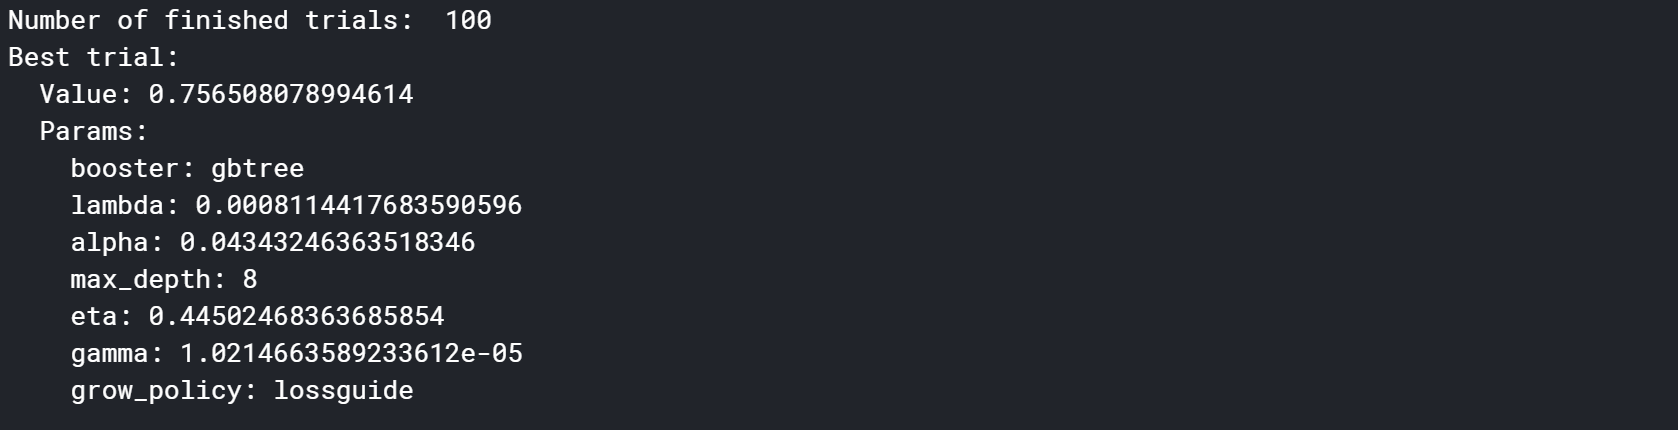

It looks like that Optuna has not improved our metrics much! 

# Model_Evaluation

In this section we will examine the following classification visualizers:
1. Classification Report
2. Confusion Matrix
3. ROC/AUC curve
5. Precision-Recall Curves
7. Class Prediction Error

For this section I will use the wonderful [yellowbrick](https://www.scikit-yb.org/en/latest/index.html) library: these guys specialize onot the model evaluations of regression, classification, clustering, text cases and many more!

**1. Classification Report**

This visualizer displays the precision, recall, F1, and support scores for the model

In [ ]:
from yellowbrick.classifier import ClassificationReport



clf = XGBClassifier()
visualizer = ClassificationReport(clf,support=True)

visualizer.fit(X_train_scaled, y_train_os)        # Fit the visualizer and the model
visualizer.score(X_test_scaled, y_test_os)        # Evaluate the model on the test data
visualizer.show() 

**2. Confusion matrix**

This takes values and returns a report showing how each of the test values predicted classes compare to their actual classes. Data scientists use confusion matrices to understand which classes are most easily confused

In [ ]:
from yellowbrick.classifier import ConfusionMatrix

cm = ConfusionMatrix(clf)

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_train_scaled, y_train_os)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_test_scaled, y_test_os)

# How did we do?
cm.show()

**3. ROC/AUC curve**


The Receiver Operating Characteristic [(ROC)](https://www.scikit-yb.org/en/latest/api/classifier/rocauc.html) is a measure of a classifier’s predictive quality that compares and visualizes the tradeoff between the model’s sensitivity and specificity. When plotted, a ROC curve displays the true positive rate on the Y axis and the false positive rate on the X axis on both a global average and per-class basis.

In [ ]:
from yellowbrick.classifier import ROCAUC

visualizer = ROCAUC(clf, classes=["0", "1"])

visualizer.fit(X_train_scaled, y_train_os)        # Fit the training data to the visualizer
visualizer.score(X_test_scaled, y_test_os)        # Evaluate the model on the test data
visualizer.show()   

**4. Precision Recall curves**


The PrecisionRecallCurve [(PRC)](https://www.scikit-yb.org/en/latest/api/classifier/prcurve.html) shows the tradeoff between a classifier’s precision, a measure of result relevancy, and recall, a measure of completeness. For each class, precision is defined as the ratio of true positives to the sum of true and false positives, and recall is the ratio of true positives to the sum of true positives and false negatives.

In [ ]:
from xgboost import XGBClassifier
from yellowbrick.classifier import PrecisionRecallCurve

# Create the visualizer, fit, score, and show it
viz = PrecisionRecallCurve(XGBClassifier(random_state=0), per_class=True,
    cmap="Set1")
viz.fit(X_train_scaled, y_train_os)
viz.score(X_test_scaled, y_test_os)
viz.show()

**5. Class Prediction Error**

Like the Classification Report, Class Prediction Error [(CPE)](https://www.scikit-yb.org/en/latest/api/classifier/class_prediction_error.html) plot shows the support (number of training samples) for each class in the fitted classification model as a stacked bar chart. Each bar is segmented to show the proportion of predictions (including false negatives and false positives, like a Confusion Matrix) for each class

In [ ]:
from yellowbrick.classifier import ClassPredictionError


visualizer = ClassPredictionError(
    XGBClassifier(random_state=42, n_estimators=10)
)

# Fit the training data to the visualizer
visualizer.fit(X_train_scaled, y_train_os)

# Evaluate the model on the test data
visualizer.score(X_test_scaled, y_test_os)

# Draw visualization
visualizer.show()

**In my opinion, this is the most illustrative-friendly way of looking at the classifier predictions:
as soon as we are mainly interested in the False Negative values, we can clearly observe those at the right column (1.0 class) marked with blue color. By eyebolling we see that False negative values occupy something around 20% or the total population of 1.0 class, providing us with recall of 80% (orange color).**

<a class = 'anchor' id = 'Deployment'></a>

# Deployment

[Deployment link](https://employee-leave-data-science.herokuapp.com/)

[The link to my github](https://github.com/valera2042/HR_analytics)

# Thank you for your attention!